In [1]:
# Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects, binary_erosion, binary_dilation
from skimage.color import rgb2lab, lab2rgb
from skimage.util import img_as_float
from skimage.transform import resize
from scipy.spatial import distance
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans, AgglomerativeClustering
from collections import Counter, defaultdict
import math
from ipywidgets import interact, IntSlider, FloatSlider, Button, VBox

# Image extraction code

## Utility functions and image import

In [2]:
# -----------------------------------------------------------------------------
# Utility Functions
# -----------------------------------------------------------------------------
def display_image(image_array, title="Image", size=(6,6)):
    """
    Display a given image array (NumPy array) with a title.
    For images with transparency, a white background is used.
    """
    if image_array.shape[-1] == 4:
        rgb = image_array[..., :3].copy()
        alpha = image_array[..., 3]
        rgb[alpha==0] = [255, 255, 255]
        img_to_show = rgb
    else:
        img_to_show = image_array
    plt.figure(figsize=size)
    plt.imshow(img_to_show)
    plt.title(title)
    plt.axis('off')
    plt.show()

def get_unique_colors(image):
    """
    Return a list of unique RGB colors in the input image.
    If the image is already flattened (i.e. shape (N,3)), it returns unique rows.
    """
    arr = image if image.ndim == 2 else image.reshape(-1, image.shape[2])
    return np.unique(arr, axis=0)


def display_palette(palette, title="Palette"):
    """
    Displays a list of RGB colors as swatches in a single row.
    """
    if not palette:
        print(f"No colors to display for {title}.")
        return
    swatch_height, swatch_width = 50, 50
    n_colors = len(palette)
    swatches = np.zeros((swatch_height, swatch_width * n_colors, 3), dtype=np.uint8)
    for i, color in enumerate(palette):
        swatches[:, i*swatch_width:(i+1)*swatch_width, :] = np.array(color, dtype=np.uint8)
    plt.figure(figsize=(max(n_colors, 8), 2))
    plt.imshow(swatches)
    plt.title(title)
    plt.axis('off')
    plt.show()


def checkered_bg(img):
  has_alpha = (img.mode in ('RGBA', 'LA'))

  if has_alpha:
      img_np = np.array(img)
      rgb_img = img_np[..., :3]           # extract RGB channels
      alpha_channel = img_np[..., 3]        # extract alpha channel
      fg_mask = alpha_channel > 0           # foreground mask from alpha

      # Get image dimensions
      height, width = rgb_img.shape[:2]

      # Adaptive tile size: 2% of the smaller dimension (ensuring at least 1 pixel)
      tile_size = max(1, int(min(height, width) * 0.02))

      # Define colors for checkered pattern
      color1 = np.array([255, 255, 255], dtype=np.uint8)  # white tile
      color2 = np.array([200, 200, 200], dtype=np.uint8)  # light gray tile

      # Create a checkered background using a vectorized approach:
      y, x = np.indices((height, width))
      checkerboard = ((x // tile_size + y // tile_size) % 2 == 0)
      background = np.where(checkerboard[..., None], color1, color2)

      # Composite the image: use rgb_img where alpha is present, else use checkered background
      display_img = np.where(fg_mask[..., None], rgb_img, background)
  else:
      img_np = np.array(img.convert('RGB'))  # ensure RGB format
      rgb_img = img_np
      fg_mask = np.ones(rgb_img.shape[:2], dtype=bool)  # all pixels are foreground
      display_img = rgb_img  # no modification needed






In [3]:

# -----------------------------------------------------------------------------
# NEW: Helper function to compute Lab distance for two RGB colors
# -----------------------------------------------------------------------------
def lab_distance(rgb1, rgb2):
    """
    Convert two RGB colors (0-255) to Lab (after scaling to [0,1]) and return the Euclidean distance.
    """
    # Convert to float and scale to [0,1]
    rgb1_arr = np.array([[list(rgb1)]], dtype=np.float64) / 255.0
    rgb2_arr = np.array([[list(rgb2)]], dtype=np.float64) / 255.0
    lab1 = rgb2lab(rgb1_arr)[0,0,:]
    lab2 = rgb2lab(rgb2_arr)[0,0,:]
    return np.linalg.norm(lab1 - lab2)

# -----------------------------------------------------------------------------
# Modified: Hierarchical clustering (reduce_palette_to_n_colors) using Lab space
# -----------------------------------------------------------------------------
def reduce_palette_to_n_colors(full_palette, target_n):
    """
    Reduce 'full_palette' to 'target_n' colors using Agglomerative Clustering in Lab space.
    """
    if target_n >= len(full_palette):
        return list(full_palette)

    # Convert palette to Lab space
    lab_palette = [rgb2lab(np.array([[list(c)]], dtype=np.float64)/255.0)[0,0,:] for c in full_palette]
    X = np.array(lab_palette, dtype=np.float64)

    clustering = AgglomerativeClustering(n_clusters=target_n, metric='euclidean', linkage='average')
    labels = clustering.fit_predict(X)

    # Compute mean color of each cluster
    new_colors_lab = [X[labels == i].mean(axis=0) for i in range(target_n)]

    # Convert back to RGB
    new_colors_rgb = [(np.clip(lab2rgb([[lab]]), 0, 1) * 255).astype(np.uint8)[0,0,:].tolist() for lab in new_colors_lab]
    return [tuple(rgb) for rgb in new_colors_rgb]

# -----------------------------------------------------------------------------
# Modified: find_nearest_color uses Lab distance for final recolor
# -----------------------------------------------------------------------------
def find_nearest_color(px, palette):
    """
    Find the nearest color to 'px' in the given palette using Lab distance.
    """
    return min(palette, key=lambda c: lab_distance(px, c))

# -----------------------------------------------------------------------------
# Modified: Merge palettes using Lab space for near-duplicate removal
# -----------------------------------------------------------------------------
def merge_palettes_remove_duplicates(palette1, palette2, threshold=5.0):
    """
    Merge two RGB palettes, removing near-duplicate colors using Lab distance.
    """
    merged = palette1 + palette2
    unique_colors = []
    for color in merged:
        if all(lab_distance(color, uc) >= threshold for uc in unique_colors):
            unique_colors.append(color)
    return unique_colors

# -----------------------------------------------------------------------------
# Modified: Recluster palette using K-Means in Lab space
# -----------------------------------------------------------------------------
def recluster_palette(color_list, final_k=10):
    """
    Apply K-Means clustering in Lab space to reduce colors to 'final_k'.
    """
    X = np.array([
        rgb2lab(np.array([[list(c)]], dtype=np.float64)/255.0)[0,0,:] for c in color_list
    ])
    kmeans = KMeans(n_clusters=final_k, random_state=42)
    kmeans.fit(X)
    centers_lab = kmeans.cluster_centers_
    centers_rgb = [(np.clip(lab2rgb([[lab]]), 0, 1) * 255).astype(np.uint8)[0,0,:].tolist() for lab in centers_lab]
    return [tuple(rgb) for rgb in centers_rgb]



In [4]:
# -----------------------------------------------------------------------------
# Step 1: File Input (Google Colab friendly)
# -----------------------------------------------------------------------------
try:
    path_input = input("Enter file path to your image (or press Enter to upload): ").strip()
except Exception as e:
    print(f"Input failed: {e}")
    path_input = ""

if path_input:
    # Use provided path
    filename = path_input
    img = Image.open(filename)
else:
    # Prompt for upload in Google Colab
    print("Please upload your image file.")
    from google.colab import files
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    img = Image.open(filename)

Enter file path to your image (or press Enter to upload): /content/totoro_no_bg.png


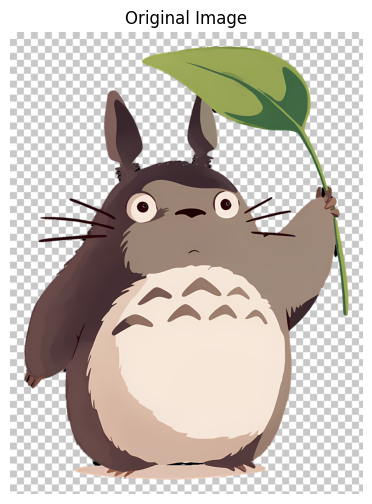

In [5]:
# -----------------------------------------------------------------------------
# Step 2: Check alpha & prepare image for processing
# -----------------------------------------------------------------------------
has_alpha = (img.mode in ('RGBA', 'LA'))

if has_alpha:
    img_np = np.array(img)
    rgb_img = img_np[..., :3]           # extract RGB channels
    alpha_channel = img_np[..., 3]        # extract alpha channel
    fg_mask = alpha_channel > 0           # foreground mask from alpha

    # Get image dimensions
    height, width = rgb_img.shape[:2]

    # Adaptive tile size: 2% of the smaller dimension (ensuring at least 1 pixel)
    tile_size = max(1, int(min(height, width) * 0.02))

    # Define colors for checkered pattern
    color1 = np.array([255, 255, 255], dtype=np.uint8)  # white tile
    color2 = np.array([200, 200, 200], dtype=np.uint8)  # light gray tile

    # Create a checkered background using a vectorized approach:
    y, x = np.indices((height, width))
    checkerboard = ((x // tile_size + y // tile_size) % 2 == 0)
    background = np.where(checkerboard[..., None], color1, color2)

    # Composite the image: use rgb_img where alpha is present, else use checkered background
    display_img = np.where(fg_mask[..., None], rgb_img, background)
else:
    img_np = np.array(img.convert('RGB'))  # ensure RGB format
    rgb_img = img_np
    fg_mask = np.ones(rgb_img.shape[:2], dtype=bool)  # all pixels are foreground
    display_img = rgb_img  # no modification needed

# Show the loaded image
height, width = rgb_img.shape[:2]
display_image(display_img, title="Original Image")

# Note: rgb_img is still the one we want to work


## Obtaining the main colors in the image



### Meanshift in Lab space

After some experimentation I decided to use the mean shift algorithm in the Lab colorspace of the image to cluster the main colors in the image. We first scale down the image and only use a subset of those pixels to calculate the bandwith used in meanshift, changing these values might produce better results but it will take longer and MS is already initialization dependent.

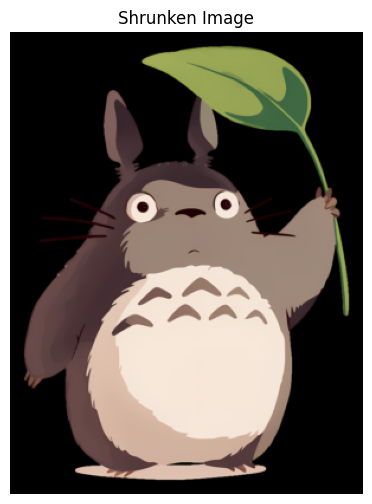

Estimating bandwidth for MeanShift on the shrunken image...
Estimated bandwidth = 5.71
Running MeanShift on the shrunken image...
MeanShift found 22 clusters.


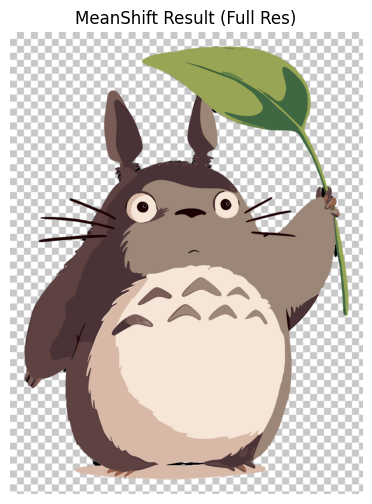

MeanShift palette has 22 colors.


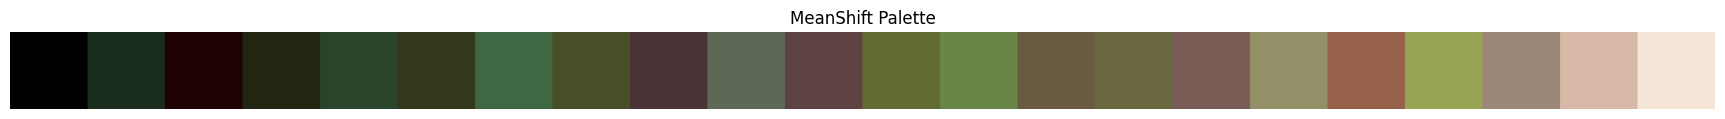

In [6]:
# -----------------------------------------------------------------------------
# Step 3: Downscale, Convert to Lab, and MeanShift Clustering
# -----------------------------------------------------------------------------
scale_factor = 0.1 # keep small if big image
newH, newW = int(height * scale_factor), int(width * scale_factor)
shrunken_img = resize(rgb_img, (newH, newW), anti_aliasing=True, preserve_range=True).astype(np.uint8)
display_image(shrunken_img, title="Shrunken Image")

# Convert to Lab and prepare for clustering
lab_small = rgb2lab(shrunken_img)
pixels_lab_small = lab_small.reshape((-1, 3))

# Sample small portion for bandwidth estimation
sample_size = int(0.1 * pixels_lab_small.shape[0])
sample_indices = np.random.choice(pixels_lab_small.shape[0], sample_size, replace=False)
sample_data_small = pixels_lab_small[sample_indices]

print("Estimating bandwidth for MeanShift on the shrunken image...")
bandwidth = estimate_bandwidth(sample_data_small, quantile=0.1, n_samples=sample_size)
print(f"Estimated bandwidth = {bandwidth:.2f}")

# Run MeanShift
print("Running MeanShift on the shrunken image...")
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(pixels_lab_small)
labels_small = ms.labels_
cluster_centers_ms = ms.cluster_centers_
print(f"MeanShift found {len(np.unique(labels_small))} clusters.")

# Apply clusters to full-resolution image
lab_full = rgb2lab(rgb_img)
pixels_lab_full = lab_full.reshape((-1, 3))
dists = distance.cdist(pixels_lab_full, cluster_centers_ms)
closest_centers = np.argmin(dists, axis=1)
new_lab_img = cluster_centers_ms[closest_centers].reshape(lab_full.shape)
new_rgb_img = lab2rgb(new_lab_img)
new_rgb_img_255 = (np.clip(new_rgb_img, 0, 1) * 255).astype(np.uint8)

# Merge alpha if present
if has_alpha:
    mean_shift_img = np.dstack((new_rgb_img_255, alpha_channel))
    display_ms = new_rgb_img_255.copy()
    display_ms = np.where(fg_mask[..., None], display_ms, background)
else:
    mean_shift_img = new_rgb_img_255
    display_ms = mean_shift_img

display_image(display_ms, title="MeanShift Result (Full Res)")

# Extract palette from result
ms_unique_colors = get_unique_colors(new_rgb_img_255[fg_mask].reshape(-1, 3))
ms_palette = [tuple(c) for c in ms_unique_colors]
print(f"MeanShift palette has {len(ms_palette)} colors.")
display_palette(ms_palette, title="MeanShift Palette")


## K-means

Now we will also use K-means to calculate the most common colors in the image, the advtange of this is we can define the number of clusters however kmeans can kind of be considered as global mean shift so images with a taint or a heavy bakground color will kind of overpower the color intensity of less prevalent colors

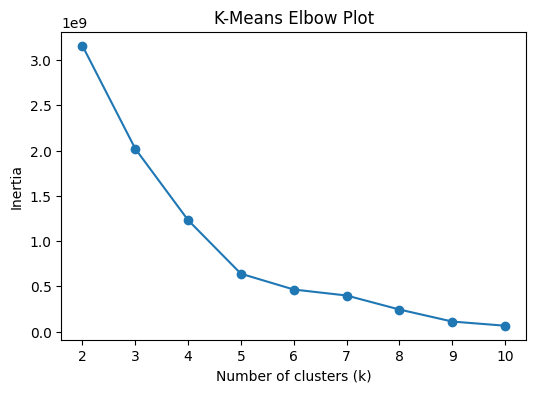

In [7]:
# -----------------------------------------------------------------------------
# Elbow Method: Determine a good 'k' by plotting inertia vs. k
# -----------------------------------------------------------------------------
k_values = range(2, 11)
inertias = []
pixels_lab = rgb2lab(display_img.astype(np.float64)/255.0).reshape((-1, 3))

for k in k_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(pixels_lab)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("K-Means Elbow Plot")
plt.show()

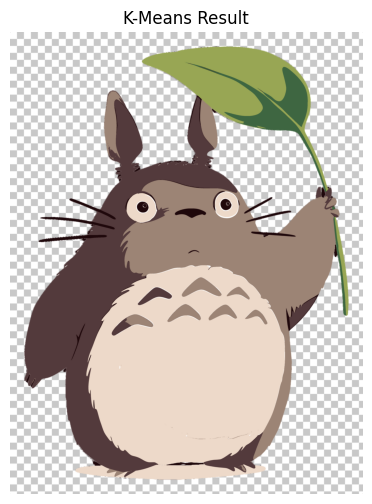

K-Means palette has 8 colors.


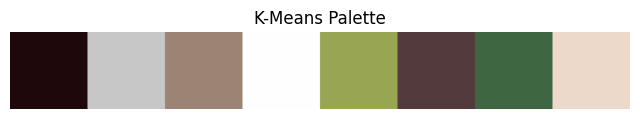

In [8]:
# -----------------------------------------------------------------------------
# Choose the number of clusters (e.g. after examining the elbow plot)
# -----------------------------------------------------------------------------
k = 8  # Change this as desired
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(pixels_lab)
labels_km = kmeans.labels_
cluster_centers_km = kmeans.cluster_centers_
cluster_centers_rgb = lab2rgb(cluster_centers_km.reshape(1, -1, 3)).reshape(-1, 3)

new_lab_img = cluster_centers_km[labels_km].reshape(lab_full.shape)
new_rgb_img = lab2rgb(new_lab_img)
new_rgb_img_255 = (np.clip(new_rgb_img, 0, 1) * 255).astype(np.uint8)

if has_alpha:
    kmeans_img = np.dstack((new_rgb_img_255, alpha_channel))
    display_km = new_rgb_img_255.copy()
    display_km = np.where(fg_mask[..., None], display_km, background)
else:
    kmeans_img = new_rgb_img_255
    display_km = kmeans_img

display_image(display_km, title="K-Means Result")
km_palette = (cluster_centers_rgb * 255).astype(np.uint8).tolist()
print(f"K-Means palette has {len(km_palette)} colors.")
display_palette(km_palette, title="K-Means Palette")


In [9]:
def optimized_recolor_image_to_palette(rgb_img, palette):
    """
    Reassign each pixel in 'rgb_img' to the closest color in 'palette' using a vectorized
    approach in Lab space.
    """
    H, W = rgb_img.shape[:2]
    lab_pixels = rgb2lab(rgb_img.astype(np.float64)/255.0).reshape(-1, 3)
    palette_arr = np.array(palette, dtype=np.uint8)
    palette_lab = rgb2lab(palette_arr[np.newaxis, ...].astype(np.float64)/255.0).reshape(-1, 3)
    nearest_indices = np.argmin(distance.cdist(lab_pixels, palette_lab), axis=1)
    return palette_arr[nearest_indices].reshape(H, W, 3)


How many final colors do you want? 8
Merging the MeanShift palette from 22 to 8 colors...
Palette is now 8 colors.
(Skipped recoloring for speed.) Using 8 colors after reduction.



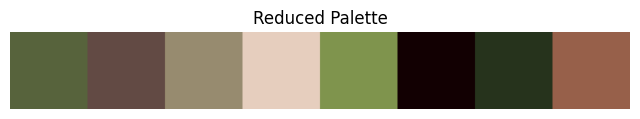

In [10]:
# -----------------------------------------------------------------------------
# Step 4: Reduce MeanShift Palette to User-defined Number of Colors
# -----------------------------------------------------------------------------
user_n = int(input("How many final colors do you want? "))
print(f"Merging the MeanShift palette from {len(ms_palette)} to {user_n} colors...")

# Reduce using hierarchical clustering in Lab space
final_palette = reduce_palette_to_n_colors(ms_palette, user_n)
print(f"Palette is now {len(final_palette)} colors.")

# Optional: Skip slow pixel-wise recoloring and just use reduced palette for next stage
# If you want to preview the recolored image, uncomment below:
# final_array = optimized_recolor_image_to_palette(mean_shift_img[..., :3] if has_alpha else mean_shift_img, final_palette)
# if has_alpha:
#     final_img_np = np.dstack((final_array, alpha_channel))
#     display_new = final_array.copy()
#     display_new[~fg_mask] = [255, 255, 255]
# else:
#     final_img_np = final_array
#     display_new = final_img_np
# display_image(display_new, title=f"Recolor with {user_n} Colors")

# Instead, just show the reduced palette
palette_after_reduce_tuples = final_palette
print(f"(Skipped recoloring for speed.) Using {len(palette_after_reduce_tuples)} colors after reduction.\n")
display_palette(palette_after_reduce_tuples, title="Reduced Palette")


Combined palette length (before re-clustering) = 15
Final palette length (after re-clustering to 8) = 8


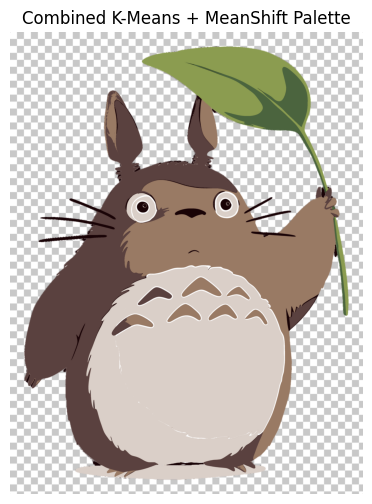

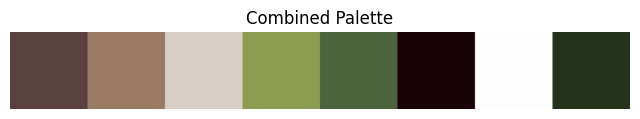

In [11]:
# -----------------------------------------------------------------------------
# Merge palettes and re-cluster using Lab distances
# -----------------------------------------------------------------------------
combined_palette = merge_palettes_remove_duplicates(km_palette, palette_after_reduce_tuples, threshold=5.0)
print(f"Combined palette length (before re-clustering) = {len(combined_palette)}")

desired_k = 8  # Change as desired
final_palette = recluster_palette(combined_palette, final_k=desired_k)
print(f"Final palette length (after re-clustering to {desired_k}) = {len(final_palette)}")

# Recolor original image with final combined palette
final_quantized_img = optimized_recolor_image_to_palette(rgb_img, final_palette)

if has_alpha:
    final_img = np.dstack((final_quantized_img, alpha_channel))
    display_final = final_quantized_img.copy()
    display_final = np.where(fg_mask[..., None], display_final, background)
else:
    final_img = final_quantized_img
    display_final = final_quantized_img

display_image(display_final, title="Combined K-Means + MeanShift Palette")
display_palette(final_palette, title="Combined Palette")


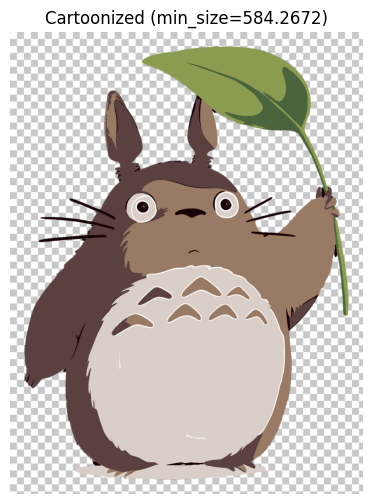

In [12]:
def remove_small_splotches_colorwise(img, min_size=1):
    """
    Removes small isolated color patches in an image by reassigning them to the most
    frequent neighboring color. Operates per unique color label.
    Optimized version uses find_objects and binary_dilation to reduce per-pixel loops.
    """

    cleaned = img.copy()
    # Find unique colors by flattening the color channels
    unique_colors = np.unique(cleaned.reshape(-1, cleaned.shape[-1]), axis=0)

    for color in unique_colors:
        # Create mask for the current color
        mask = np.all(cleaned == color, axis=-1)
        # Label connected regions in the mask
        labeled_mask, num_labels = label(mask, structure=np.ones((3, 3)))
        # Get slices for each connected component
        slices = find_objects(labeled_mask)
        if slices is None:
            continue

        for label_id, slc in enumerate(slices, start=1):
            # Extract the region for the current label within its bounding box
            region = (labeled_mask[slc] == label_id)
            region_size = np.sum(region)
            if region_size < min_size:
                # Compute the dilated region and subtract the original region to get neighbors
                dilated = binary_dilation(region, structure=np.ones((3, 3)))
                neighbor_mask = dilated & (~region)
                # Get neighbor coordinates relative to the slice, then convert to image coordinates
                neighbor_coords = np.argwhere(neighbor_mask)
                if neighbor_coords.size == 0:
                    continue
                # Adjust coordinates to full image indices
                neighbor_coords[:, 0] += slc[0].start
                neighbor_coords[:, 1] += slc[1].start
                # Gather neighbor colors
                neighbor_colors = [tuple(cleaned[r, c]) for r, c in neighbor_coords]
                if neighbor_colors:
                    most_common_color = Counter(neighbor_colors).most_common(1)[0][0]
                    # Update all pixels in the connected region at once
                    region_coords = np.argwhere(labeled_mask[slc] == label_id)
                    for r_offset, c_offset in region_coords:
                        cleaned[r_offset + slc[0].start, c_offset + slc[1].start] = most_common_color
    return cleaned

# Determine a size threshold for removing splotches
percent_size = 0.5  # percent of total image area
min_size_threshold = percent_size * (width * height) / (100 * 100)

# Apply cartoon-style cleanup
cartoonized_img = remove_small_splotches_colorwise(final_quantized_img, min_size=min_size_threshold)
if has_alpha:
    final_img = np.dstack((cartoonized_img, alpha_channel))
    display_final = cartoonized_img.copy()
    display_final = np.where(fg_mask[..., None], display_final, background)
else:
    final_img = cartoonized_img
    display_final = cartoonized_img

display_image(display_final, title=f"Cartoonized (min_size={min_size_threshold})")


# Image Layering

In [21]:
from collections import defaultdict, deque
from ipywidgets import interact, IntSlider, FloatSlider, Button, VBox
from IPython.display import display
from ipywidgets import Button
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects, binary_erosion
import heapq  # We'll use heapq as a priority queue for topological sort

In [22]:
image_for_cc = display_final.copy()

In [23]:
# ---------------- Helper Functions ----------------

def compute_circumference(mask):
    """
    Compute the perimeter of a connected component using binary erosion.
    """
    edge_mask = binary_dilation(mask, np.ones((3,3))) ^ mask
    return np.sum(edge_mask)

def get_component_image(element, has_alpha=False):
    """
    Given an element (with keys "bbox", "mask", "color"), create an image of its bounding box
    with the component painted in its color.
    """
    y_min, y_max, x_min, x_max = element["bbox"]
    height = y_max - y_min
    width = x_max - x_min
    if has_alpha:
        comp_img = np.dstack((
            255*np.ones((height, width), dtype=np.uint8),
            255*np.ones((height, width), dtype=np.uint8),
            255*np.ones((height, width), dtype=np.uint8),
            np.zeros((height, width), dtype=np.uint8)
        ))
        comp_img[element["mask"]] = list(element["color"]) + [255]
    else:
        comp_img = 255 * np.ones((height, width, 3), dtype=np.uint8)
        comp_img[element["mask"]] = element["color"]

    return comp_img

def display_components_grid(layers_dict, has_alpha=False):
    """
    Display a grid where each row corresponds to a layer and each cell shows the component image.
    """
    layer_numbers = sorted(layers_dict.keys())
    if not layer_numbers:
        print("No layers to display.")
        return

    max_cols = max(len(layers_dict[layer]) for layer in layer_numbers)

    fig, axes = plt.subplots(nrows=len(layer_numbers), ncols=max_cols, figsize=(max_cols*3, len(layer_numbers)*3))
    if len(layer_numbers) == 1:
        axes = np.expand_dims(axes, axis=0)
    if max_cols == 1:
        axes = np.expand_dims(axes, axis=1)

    for row_idx, layer in enumerate(layer_numbers):
        components = layers_dict[layer]
        for col_idx in range(max_cols):
            ax = axes[row_idx, col_idx]
            if col_idx < len(components):
                comp_img = get_component_image(components[col_idx], has_alpha=has_alpha)
                ax.imshow(comp_img)
                ax.set_title(f"ID {components[col_idx]['id']}")
            else:
                ax.axis('off')
            if col_idx == 0:
                ax.set_ylabel(f"Layer {layer}", rotation=0, size='large', labelpad=40)
            ax.axis('off')
    plt.tight_layout()
    plt.show()


In [24]:
# ---------------- More Helper Functions ----------------


def get_global_mask(elem, full_shape):
    """Create a full-size binary mask for an element using its bbox and local mask."""
    global_mask = np.zeros(full_shape, dtype=bool)
    y_min, y_max, x_min, x_max = elem["bbox"]
    global_mask[y_min:y_max, x_min:x_max] = elem["mask"]
    return global_mask

def is_element_inside(inner, outer, full_shape, threshold=0.95):
    """
    Determine if 'inner' is mostly inside 'outer' using pixel-level masks.
    Returns True if at least 'threshold' fraction of inner's pixels are contained in outer.
    """
    y1, y2, x1, x2 = inner["bbox"]
    oy1, oy2, ox1, ox2 = outer["bbox"]
    if oy1 > y1 or oy2 < y2 or ox1 > x1 or ox2 < x2:
        return False
    inner_global = get_global_mask(inner, full_shape)
    outer_global = get_global_mask(outer, full_shape)
    inner_region = inner_global[y1:y2, x1:x2]
    outer_region = outer_global[y1:y2, x1:x2]
    if inner_region.sum() == 0:
        return False
    overlap = np.logical_and(inner_region, outer_region).sum()
    return (overlap / inner_region.sum()) >= threshold

def is_outline(elem, fill_ratio_thresh=0.1, max_outline_area=20):
    """
    Determine if an element appears to be merely an outline.
    Uses binary erosion on the element’s mask; if erosion removes all pixels
    (i.e. the mask is only 1-pixel thick) and the element's area is below
    max_outline_area, then if its fill ratio is below fill_ratio_thresh,
    the element is considered an outline.
    """
    eroded = binary_erosion(elem["mask"], structure=np.ones((3,3)))
    if eroded.sum() == 0 and elem["area"] <= max_outline_area:
        y_min, y_max, x_min, x_max = elem["bbox"]
        bbox_area = (y_max - y_min) * (x_max - x_min)
        if bbox_area > 0:
            fill_ratio = elem["area"] / bbox_area
            if fill_ratio < fill_ratio_thresh:
                return True
    return False

def are_adjacent(elem1, elem2, dilation=1):
    """
    Determine if two elements are adjacent based on their bounding boxes.
    Their bboxes are dilated by 'dilation' pixels; if the dilated boxes overlap,
    the elements are considered adjacent.
    """
    y1, y2, x1, x2 = elem1["bbox"]
    y1o, y2o, x1o, x2o = elem2["bbox"]
    y1_d, y2_d = y1 - dilation, y2 + dilation
    x1_d, x2_d = x1 - dilation, x2 + dilation
    y1o_d, y2o_d = y1o - dilation, y2o + dilation
    x1o_d, x2o_d = x1o - dilation, x2o + dilation
    if x2_d < x1o_d or x2o_d < x1_d:
        return False
    if y2_d < y1o_d or y2o_d < y1_d:
        return False
    return True

# --------------- Union-Find Helpers ----------------
def uf_find(parent, i):
    if parent[i] != i:
        parent[i] = uf_find(parent, parent[i])
    return parent[i]

def uf_union(parent, rank, i, j):
    i_id = uf_find(parent, i)
    j_id = uf_find(parent, j)
    if i_id == j_id:
        return
    if rank[i_id] < rank[j_id]:
        parent[i_id] = j_id
    elif rank[i_id] > rank[j_id]:
        parent[j_id] = i_id
    else:
        parent[j_id] = i_id
        rank[i_id] += 1


In [25]:
# ---------------- Global Variables for Storage ----------------

# This will hold the *most recent* layer-images computed by `run_layering`.
# We update it every time the user changes a slider.
layer_images_temp = []

# This will hold the final “approved” layer-images after the user clicks the button.
layer_images = []


# ---------------- Main Function with Dynamic Parameters ----------------

def run_layering(alpha=100, merge_threshold=3, fill_ratio_thresh=0.1, max_outline_area=20, adj_dilation=1):
    """
    Run the segmentation and layering pipeline with dynamic parameters.

    Parameters:
      alpha: Tuning constant for the priority formula.
      merge_threshold: Maximum difference between layer numbers (for same-color elements) to merge.
      fill_ratio_thresh: Fill ratio threshold for outline detection.
      max_outline_area: Maximum area for an element to be considered for outline removal.
      adj_dilation: Number of pixels to dilate bounding boxes when determining adjacency.
    """
    global layer_images_temp

    # Assumed globals:
    # - image_for_cc: RGB NumPy array (cartoonized image)
    # - final_palette: list of RGB tuples
    # - fg_mask: Boolean foreground mask
    # - compute_circumference(mask): function to compute perimeter
    # The final images are displayed in a grid.

    all_elements = []
    element_id = 0
    min_component_area = 10   # Skip very tiny segments

    # Step 1: Extract Connected Components for Each Color.
    for color in final_palette:
        mask = np.all(image_for_cc == color, axis=-1)
        mask &= fg_mask
        labeled_array, num_features = label(mask, structure=np.ones((3,3), dtype=int))
        slices = find_objects(labeled_array)

        for comp_index, sl in enumerate(slices, start=1):
            comp_mask = (labeled_array[sl] == comp_index)
            comp_size = np.sum(comp_mask)
            if comp_size < min_component_area:
                continue
            circumference = compute_circumference(comp_mask)
            bbox = (sl[0].start, sl[0].stop, sl[1].start, sl[1].stop)
            complexity = circumference / comp_size if comp_size > 0 else float('inf')

            elem = {
                "id": element_id,
                "color": color,
                "area": comp_size,
                "circumference": circumference,
                "bbox": bbox,
                "mask": comp_mask,  # Local coordinates within bbox.
                "enveloped_by": None,
                "layer": None,
                "complexity": complexity
            }
            all_elements.append(elem)
            element_id += 1

    all_elements = [e for e in all_elements if e["area"] >= min_component_area]

    # Step 2: Remove Outline-like Elements.
    all_elements = [e for e in all_elements if not is_outline(e, fill_ratio_thresh=fill_ratio_thresh, max_outline_area=max_outline_area)]

    # Step 3: Determine Engulfing Relationships.
    full_shape = image_for_cc.shape[:2]
    for elem in all_elements:
        candidate_parents = []
        for other in all_elements:
            if other["id"] == elem["id"]:
                continue
            if is_element_inside(elem, other, full_shape, threshold=0.95):
                candidate_parents.append(other)
        if candidate_parents:
            parent_elem = min(candidate_parents, key=lambda f: f["area"])
            elem["enveloped_by"] = parent_elem["id"]

    # Step 4: Compute Combined Priority.
    for e in all_elements:
        e["priority"] = e["complexity"] + alpha * (1.0 / e["area"])

    # Step 5: Preliminary Layer Assignment.
    sorted_elements = sorted(all_elements, key=lambda e: e["priority"], reverse=True)
    for i, e in enumerate(sorted_elements):
        e["layer"] = i + 1
    for e in sorted_elements:
        if e["enveloped_by"] is not None:
            parent_elem = next((p for p in sorted_elements if p["id"] == e["enveloped_by"]), None)
            if parent_elem and e["layer"] <= parent_elem["layer"]:
                e["layer"] = parent_elem["layer"] + 1

    # Step 6: Merge Adjacent Same-Color Elements (using union-find).
    n = len(sorted_elements)
    parent = list(range(n))
    rank = [0] * n
    color_to_indices = defaultdict(list)
    for idx, e in enumerate(sorted_elements):
        color_to_indices[e["color"]].append(idx)
    for color, indices in color_to_indices.items():
        for i in range(len(indices)):
            for j in range(i+1, len(indices)):
                idx_i = indices[i]
                idx_j = indices[j]
                if are_adjacent(sorted_elements[idx_i], sorted_elements[idx_j], dilation=adj_dilation):
                    uf_union(parent, rank, idx_i, idx_j)
    group_min_layer = {}
    for i in range(n):
        root = uf_find(parent, i)
        group_min_layer[root] = min(group_min_layer.get(root, float('inf')), sorted_elements[i]["layer"])
    for i in range(n):
        root = uf_find(parent, i)
        sorted_elements[i]["layer"] = group_min_layer[root]

    # Step 7: Merge Nearby Layers for the Same Color.
    merge_thresh = merge_threshold
    color_groups = defaultdict(list)
    for e in sorted_elements:
        color_groups[e["color"]].append(e)
    for color, group in color_groups.items():
        group.sort(key=lambda x: x["layer"])
        current_cluster = [group[0]]
        for e in group[1:]:
            if e["layer"] - current_cluster[-1]["layer"] <= merge_thresh:
                current_cluster.append(e)
            else:
                common_layer = min(x["layer"] for x in current_cluster)
                for x in current_cluster:
                    x["layer"] = common_layer
                current_cluster = [e]
        if current_cluster:
            common_layer = min(x["layer"] for x in current_cluster)
            for x in current_cluster:
                x["layer"] = common_layer

    # Step 8: Build the layer_images list and display them.
    layers_dict = defaultdict(list)
    for e in sorted_elements:
        layers_dict[e["layer"]].append(e)

    H, W = image_for_cc.shape[:2]
    new_layer_images = []
    for layer in sorted(layers_dict.keys()):
        layer_img = 255 * np.ones((H, W, 3), dtype=np.uint8)  # White background
        for elem in layers_dict[layer]:
            y_min, y_max, x_min, x_max = elem["bbox"]
            layer_img[y_min:y_max, x_min:x_max][elem["mask"]] = np.array(elem["color"], dtype=np.uint8)
        new_layer_images.append((layer, layer_img))

    # Update the global "temp" images (latest result).
    layer_images_temp = new_layer_images

    # --- Display the images in a grid ---
    n_layers = len(new_layer_images)
    ncols = min(n_layers, 5)
    nrows = math.ceil(n_layers / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.expand_dims(axes, axis=0)
    elif ncols == 1:
        axes = np.expand_dims(axes, axis=1)

    for idx, (layer, img) in enumerate(new_layer_images):
        row = idx // ncols
        col = idx % ncols
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"Layer {layer}")
        axes[row, col].axis('off')
    for idx in range(n_layers, nrows * ncols):
        row = idx // ncols
        col = idx % ncols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()


# ---------------- Interactive Sliders ----------------
_ = interact(run_layering,
             alpha=IntSlider(value=100, min=10, max=300, step=10, description="Alpha"),
             merge_threshold=IntSlider(value=3, min=1, max=100, step=1, description="Merge Thresh"),
             fill_ratio_thresh=FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description="Fill Ratio Thresh"),
             max_outline_area=IntSlider(value=20, min=1, max=100, step=1, description="Max Outline Area"),
             adj_dilation=IntSlider(value=1, min=0, max=20, step=1, description="Adjacency Dilation"))

# ---------------- Button to Save the Final Layer Images Globally ----------------
save_button = Button(description="Save Layer Images to Global")

def on_save_button_clicked(b):
    """
    When clicked, copies the current layer_images_temp
    into the global 'layer_images' variable.
    """
    global layer_images_temp, layer_images
    if len(layer_images_temp) == 0:
        print("No layering results found. Adjust sliders and let run_layering generate images first.")
    else:
        layer_images = layer_images_temp
        print("Successfully saved the current layering to the global variable 'layer_images'.")

save_button.on_click(on_save_button_clicked)

display(VBox([save_button]))


interactive(children=(IntSlider(value=100, description='Alpha', max=300, min=10, step=10), IntSlider(value=3, …

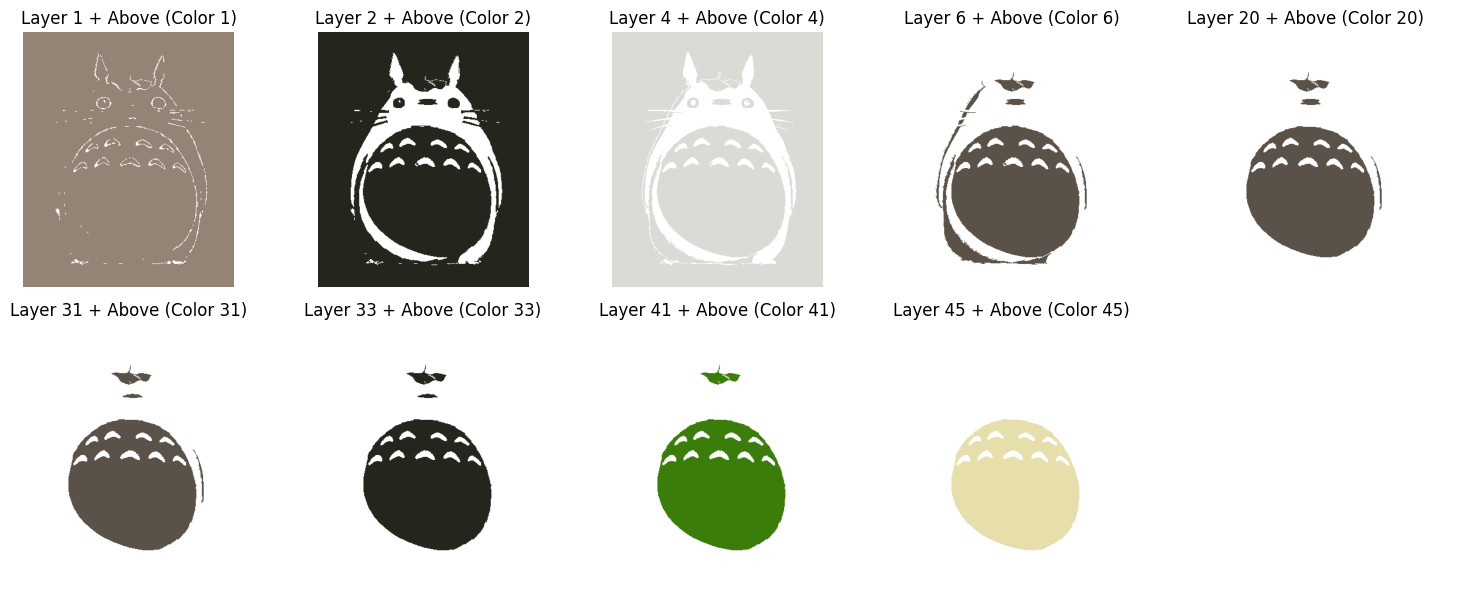

In [ ]:
amalgamation_images = []

if len(layer_images) == 0:
    print("No layers found in 'layer_images'. Please run your pipeline first.")
else:
    # We will create a new image for each layer i that includes
    # all shapes from layer i+1..end, but colored with layer i's color.

    for i in range(len(layer_images)):
        layer_num_i, base_img_i = layer_images[i]

        # Make a copy so we can modify it
        amalgam = np.copy(base_img_i)

        # Detect the base color for layer i by looking for the first non-white pixel
        mask_i = np.any(base_img_i != [255, 255, 255], axis=-1)
        coords_i = np.argwhere(mask_i)

        if len(coords_i) == 0:
            # This layer is completely white; there's no “color.” We'll do nothing special,
            # so it stays all white unless subsequent layers' shapes are added (colored white).
            # We can just store it as-is and move on, but it won't change.
            color_i = np.array([255, 255, 255], dtype=np.uint8)
        else:
            # Use the first non-white pixel as the base color
            y_i, x_i = coords_i[0]
            color_i = base_img_i[y_i, x_i]

        # Now incorporate shapes from layers above i
        for j in range(i+1, len(layer_images)):
            # The shape from layer j
            _, layer_img_j = layer_images[j]
            # Identify the painted (non-white) pixels in layer j
            mask_j = np.any(layer_img_j != [255, 255, 255], axis=-1)
            # Overwrite those pixels in 'amalgam' with layer i's color
            amalgam[mask_j] = color_i

        # Store this new image
        amalgamation_images.append((layer_num_i, amalgam))

    # --------------- Display the results in a grid ---------------
    n_layers = len(amalgamation_images)
    ncols = min(n_layers, 5)
    nrows = math.ceil(n_layers / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))

    # Ensure axes is always a 2D array
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.expand_dims(axes, axis=0)
    elif ncols == 1:
        axes = np.expand_dims(axes, axis=1)

    for idx, (layer_num, img) in enumerate(amalgamation_images):
        row = idx // ncols
        col = idx % ncols
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"Layer {layer_num} + Above (Color {layer_num})")
        axes[row, col].axis('off')

    # Turn off any leftover subplots if our grid is larger
    for idx in range(n_layers, nrows*ncols):
        row = idx // ncols
        col = idx % ncols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()
